# WorldCover Statistics – Example

This notebook demonstrates how to use the **WorldCover Statistics** service, which is hosted on the CDSE openEO backend and published in the [APEx Algorithm Catalogue](https://algorithm-catalogue.apex.esa.int/).  
It provides a step-by-step walkthrough showing how to execute the service and retrieve land cover statistics for your area of interest.


In [21]:
%pip install esa-apex-algorithms openeo pandas matplotlib folium shapely geojson

In [38]:
import esa_apex_toolbox
import openeo
import pandas as pd
import folium
from shapely.geometry import shape
import matplotlib.pyplot as plt

In [3]:
from esa_apex_toolbox.algorithms import GithubAlgorithmRepository

## Discover the WorldCover Statistics Algorithm

We use the Python API of the APEx algorithm catalogue to easily explore the available algorithms and their metadata.  
This approach removes the need to manually copy and paste algorithm links, making the workflow more robust and reproducible.

In [10]:
repo = GithubAlgorithmRepository(
            owner="ESA-APEx",
            repo="apex_algorithms",
            folder="algorithm_catalog",
        )

In [11]:
repo.list_algorithms()

['RAMONA-herbaceous_rangeland_biomass-country-mosaick',
 'wind_turbine',
 'sen2like',
 'eurac_pv_farm_detection',
 'gep_bas',
 'gep_ost',
 'sar_coin',
 'snap_insar_sentinel1_iw_slc',
 'bap_composite',
 'biopar',
 'max_ndvi',
 'max_ndvi_composite',
 'mogpr_s1s2',
 'parcel_delineation',
 'peakvalley',
 'phenology',
 'random_forest_firemapping',
 'sentinel1_stats',
 'variabilitymap',
 'whittaker',
 'worldcereal_crop_extent',
 'worldcereal_crop_type',
 'worldcover_statistics',
 'worldagrocommodities']

In [12]:
worldcover_stats = repo.get_algorithm('worldcover_statistics')
worldcover_stats

Algorithm(id='worldcover_statistics', title='Land cover statistics based on ESA WorldCover data for 2021, provided by Terrascope.', description='For a given geometry or set of geometries, computes percentage landcover for 2021.', udp_link=UdpLink(href='https://raw.githubusercontent.com/ESA-APEx/apex_algorithms/refs/heads/main/algorithm_catalog/vito/worldcover_statistics/openeo_udp/worldcover_statistics.json', title='openEO Process Definition'), service_links=[ServiceLink(href='https://openeofed.dataspace.copernicus.eu', title='openEO platform')], license=None, organization='Terrascope')

## Run the Algorithm in openEO

To execute the algorithm in openEO, first connect to the backend and authenticate using your user account.  
Once authenticated, you can submit processing requests and run the service.

In [14]:
connection = openeo.connect(worldcover_stats.service_links[0].href).authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=ZWBP-HZZC to authenticate.
Authorized successfully                                                         
Authenticated using device code flow.


### Define the Area of Interest

Before running the land cover calculation, we first need to define the area of interest.  
This spatial extent determines where the statistics will be computed.

In [15]:
aoi =  {
        "coordinates": [
          [
            [
              6.328885950057327,
              46.89383161990338
            ],
            [
              6.328885950057327,
              46.16912106552846
            ],
            [
              7.549722603596138,
              46.16912106552846
            ],
            [
              7.549722603596138,
              46.89383161990338
            ],
            [
              6.328885950057327,
              46.89383161990338
            ]
          ]
        ],
        "type": "Polygon"
}

In [33]:
geometry = shape(aoi)
centroid = geometry.centroid
m = folium.Map(
    location=[centroid.y, centroid.x],
    zoom_start=8
)
folium.WmsTileLayer(
    url="https://services.terrascope.be/wms/v2",
    layers="WORLDCOVER_2021_MAP",
    name="WorldCover 2021",
    srs="EPSG:3857",
    fmt="image/png",
    transparent=True,
    version="1.3.0",
    attr="© Terrascope"
).add_to(m)

folium.GeoJson(
    aoi,
    name="Area of Interest"
).add_to(m)
m

### Execute the Service through openEO

Now that everything is set up, we can execute the service through openEO and visualise the results.  
The following steps submit the processing request and retrieve the output for inspection.

In [29]:
connection.datacube_from_process(
    namespace = worldcover_stats.udp_link.href,
    process_id = worldcover_stats.id,
    geometries = aoi
).save_result(format="CSV").execute_batch("worldcover_stats.csv")

0:00:00 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': send 'start'
0:00:15 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': queued (progress 0%)
0:00:21 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': queued (progress 0%)
0:00:27 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': queued (progress 0%)
0:00:36 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': queued (progress 0%)
0:00:46 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': queued (progress 0%)
0:00:58 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': queued (progress 0%)
0:01:14 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': running (progress N/A)
0:01:34 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': running (progress N/A)
0:01:59 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': running (progress N/A)
0:02:30 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': running (progress N/A)
0:03:08 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': running (progress N/A)
0:03:56 Job 'cdse-j-25121913270447a19fd0b6af4a50abf3': running (progress N/A)
0:04:56 

<BatchJob job_id='cdse-j-25121913270447a19fd0b6af4a50abf3'>

In [30]:
df = pd.read_csv("worldcover_stats.csv")
df.date = pd.to_datetime(df.date)
df.set_index(["date","feature_index"],inplace=True)
df

,,treecover,shrubland,grassland,cropland,builtup,bare/sparse vegetation,snow and ice,water,herbaceous wetland,mangroves,moss and lichen
date,feature_index,,,,,,,,,,,
2021-01-01 00:00:00+00:00,0,0.404512,0.000033,0.345542,0.103134,0.038537,0.020193,0.00581,0.079298,0.000028,0.0,0.002913


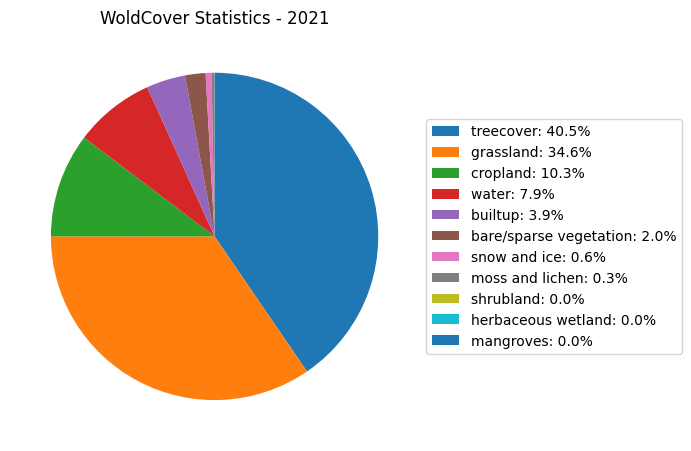

In [84]:
df_T = df.T
num_charts = len(df_T.columns)

fig, axes = plt.subplots(1, num_charts, figsize=(7*num_charts, 7))

if num_charts == 1:
    axes = [axes]

for ax, col in zip(axes, df_T.columns):
    # Sort values largest to smallest
    data = df_T[col].sort_values(ascending=False)
    
    # Pie chart without labels or percentages
    wedges, texts = ax.pie(
        data,
        labels=None,
        startangle=90,
        counterclock=False
    )
    
    ax.set_ylabel("")
    ax.set_title("WoldCover Statistics - 2021")

    # Legend with values and percentages
    legend_labels = [f"{idx}: {val/data.sum()*100:.1f}%" for idx, val in data.items()]
    
    ax.legend(
        wedges,
        legend_labels,
        loc='center left',
        bbox_to_anchor=(1, 0.5)
    )

plt.tight_layout()
plt.show()